In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [5]:
image_path = 'C:/Users/pirat/Desktop/New folder (4) - Copy/fracture'

In [4]:
data = pd.read_csv("encoded-fracture331.csv")
data.head()

,images,description
0,f (1).jpg,This is a fracture of the lateral malleolus of...
1,f (2).jpg,This is an oblique fracture of the tibia. The ...
2,f (3).jpg,"This is a fracture of the neck of the femur, w..."
3,f (4).jpg,This is a fracture of the shaft of the fibula ...
4,f (5).jpg,This is an oblique fracture of the shaft of th...


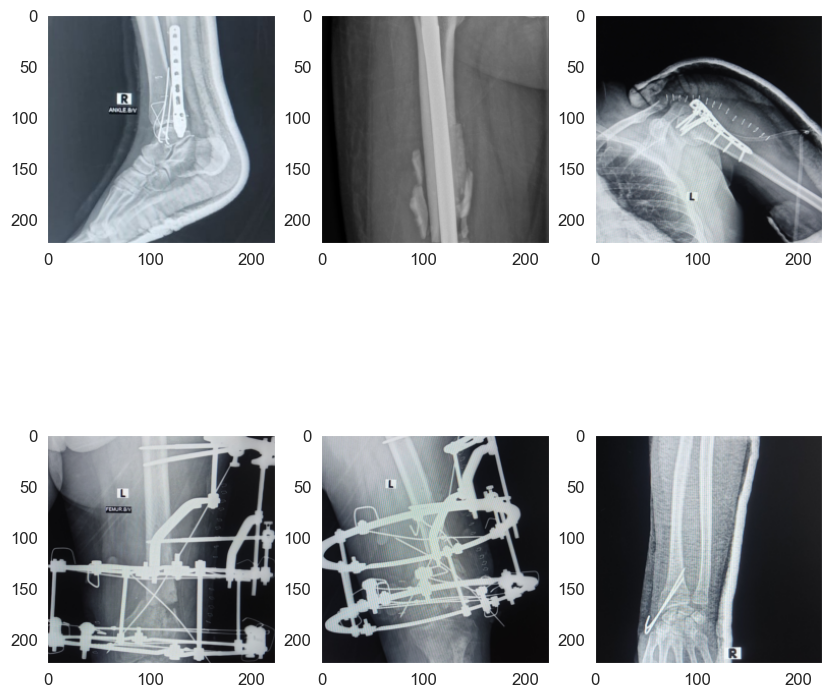

In [15]:
#load the image information
from tensorflow.keras.preprocessing.image import load_img,img_to_array

def load_data(): # return all image file path and name
    import glob
    file_name = []
    file_path= os.path.join('C:/Users/pirat/Desktop/New folder (4) - Copy/fracture', '*')
    
    for filename in sorted(glob.glob(file_path)):
        file_name.append(filename)

    file_name = np.asarray(file_name)
    return file_name

def readImage(path,img_size=299):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size),interpolation='bilinear',keep_aspect_ratio=True)
    img = img_to_array(img)
    img = img/255.
    
    return img

# call the load_data function and test if they work

file_name = load_data()
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
axs = axs.flatten()
for i in range(6):
    img = readImage(file_name[i],224)
    axs[i].imshow(img)

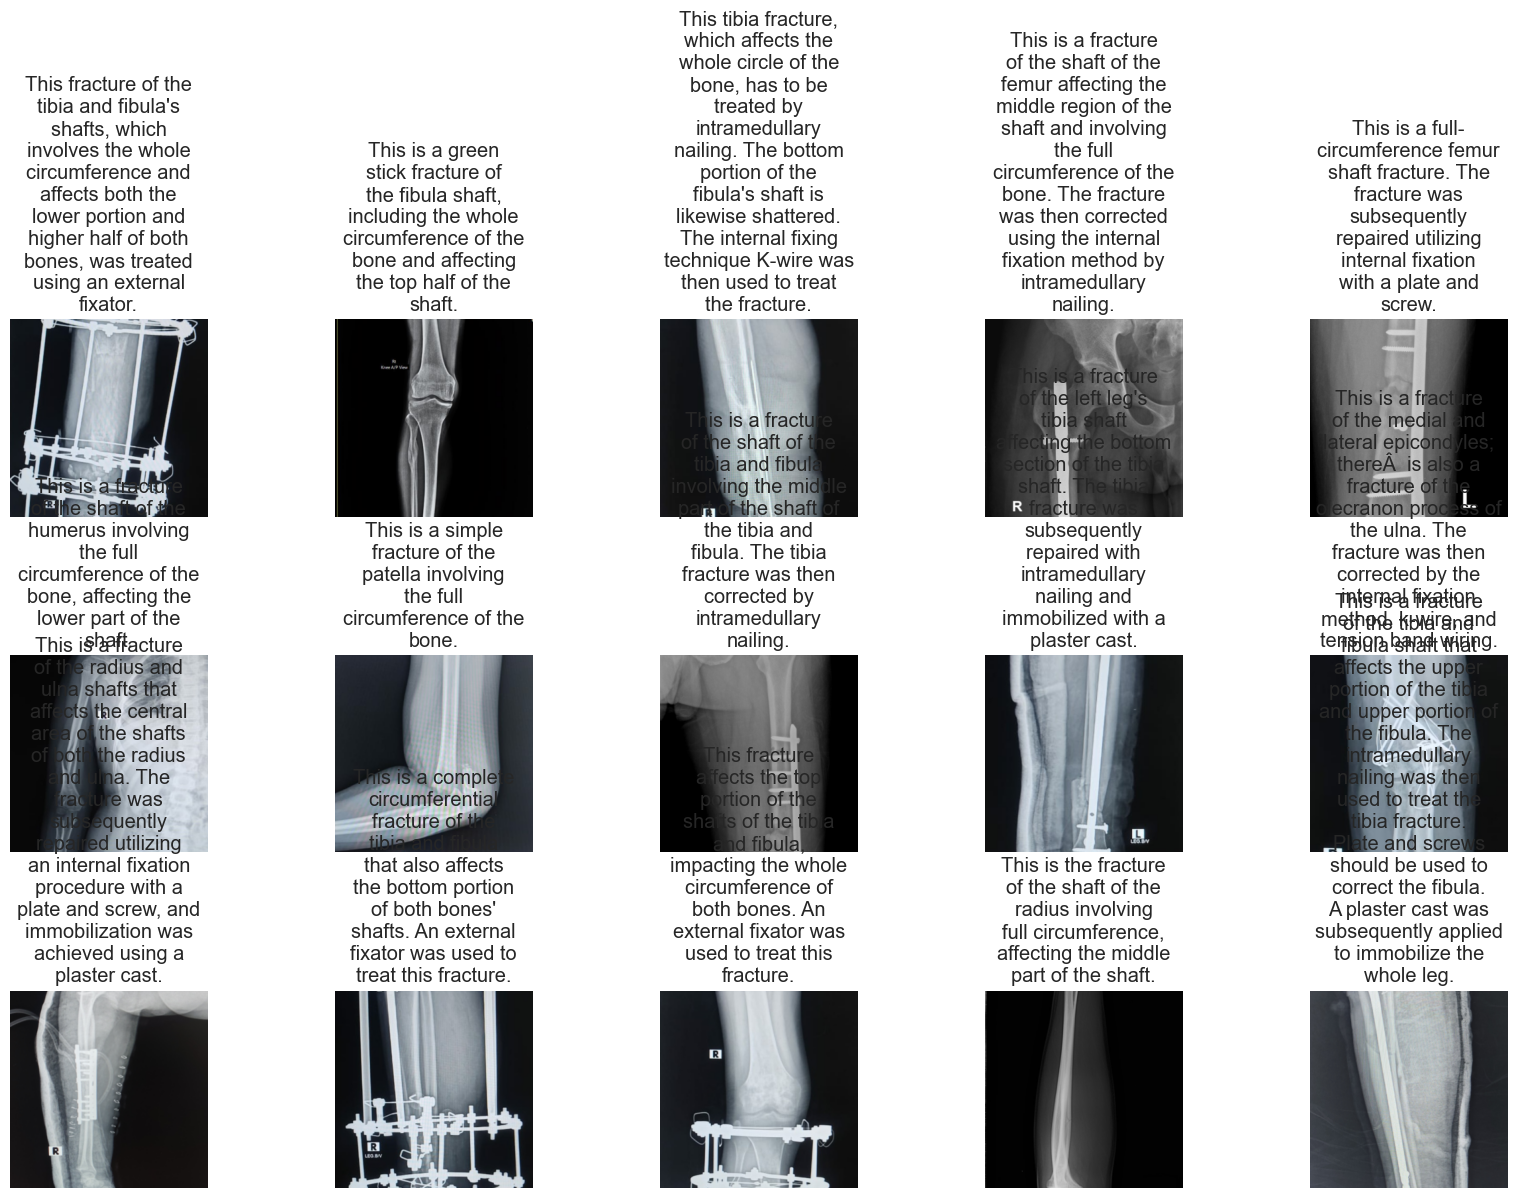

In [18]:
#Display image - code from https://www.kaggle.com/code/quadeer15sh/flickr8k-image-captioning-using-cnns-lstms
# display 15 images with the first caption from the metadata
def display_images(temp_df):
    from textwrap import wrap
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"C:/Users/pirat/Desktop/New folder (4) - Copy/fracture/{temp_df.images[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.description[i], 20)))
        plt.axis("off")
        
display_images(data.sample(15))

In [22]:
def text_preprocessing(data):
    data['description'] = data['description'].apply(lambda x: x.lower()) # convert sentences into lowercase
    data['description'] = data['description'].apply(lambda x: x.replace("[^A-Za-z]","")) # remove all character that is not a-z (remove punctation and number character)
    #data['caption'] = data['caption'].apply(lambda x: x.replace('is', "").replace('are',"")) #remove 'is' and 'are'
    data['description'] = data['description'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1])) # remove single character
    data['description'] = "startseq "+data['description']+" endseq" # added header - startseq and footer -endseq to each caption
    return data

data = text_preprocessing(data)
images = data['images'].unique().tolist()
nimages = len(images)
captions = data['description'].tolist()
ncaptions = len(captions)
print('Total number of image are :'+ str(nimages))
print('Total caption length are : '+str(ncaptions))
captions[:10]

Total number of image are :331
Total caption length are : 331


['startseq startseq startseq this is fracture of the lateral malleolus of the tibia and shaft of the fibula involving the lower part of the shaft. the fracture involved the full circumference of the bone, which was then corrected by using various methods of internal fixation such as plate and screw,k wire, and tension band wire. endseq endseq endseq',
 'startseq startseq startseq this is an oblique fracture of the tibia. the fracture involves the full circumference of the bone, which was corrected by internal fixation using an intramedullary nail. endseq endseq endseq',
 'startseq startseq startseq this is fracture of the neck of the femur, which involves the entire circumference of the bone. the fracture was then corrected by using the internal fixation method. endseq endseq endseq',
 'startseq startseq startseq this is fracture of the shaft of the fibula involving the lower part of the shaft and the full circumference of the bone. the fracture was then corrected by using internal fix

In [23]:
def cap_generator_dict(data):
    caption_dict = {}
    all_caption = []

    for _, row in data.iterrows():
        image_id = row['images']
        caption = row['description']

        # Store the caption in the caption_dict based on the image ID
        if image_id not in caption_dict:
            caption_dict[image_id] = []
        caption_dict[image_id].append(caption)

        # Save the caption in the all_caption list
        all_caption.append(caption)

    return caption_dict, all_caption

In [24]:
caption_dict, all_caption = cap_generator_dict(data)

# Access captions for a specific image ID from the caption_dict
image_id = 'f (327).jpg'

# print all captions for this image
print (caption_dict[image_id])
# Print length of total caption 
print(len(all_caption))

['startseq startseq startseq this is fracture of the shaft of the humerus involving the full circumference of the bone, affecting the lower part of the shaft. the fracture was corrected by using plate and screw. endseq endseq endseq']
331


In [26]:
import random
#train validation test split - 80% train 10% validation 10% test
image_id = list(caption_dict.keys())

random.shuffle(image_id)

train_split = int(len(image_id) * 0.8)
test_split = int(len(image_id) * 0.85)

train = image_id[:train_split]
test = image_id[train_split:test_split]
validation = image_id[test_split:]

print("Train set size:", len(train))
print("Test set size:", len(test))
print("Validation set size:", len(validation))

Train set size: 264
Test set size: 17
Validation set size: 50


In [27]:
#tutorial from https://www.kaggle.com/code/satishgunjal/tokenization-in-nlp/notebook
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)

vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size (+1 for the padding token) 
max_length = max(len(caption.split()) for caption in captions) #biggest number of caption for the image

transforms_sequence = tokenizer.texts_to_sequences([captions[0]]) # child in pink dress climbing up set of stairs in an entry way
print(transforms_sequence)

sequence_to_text = tokenizer.sequences_to_texts(transforms_sequence)
print(sequence_to_text)

[[2, 2, 2, 7, 9, 5, 4, 1, 76, 105, 4, 1, 15, 8, 6, 4, 1, 25, 13, 1, 29, 20, 4, 1, 6, 1, 5, 52, 1, 14, 11, 4, 1, 10, 38, 12, 32, 19, 16, 17, 151, 116, 4, 21, 23, 106, 77, 34, 8, 27, 117, 39, 8, 70, 71, 39, 3, 3, 3]]
['startseq startseq startseq this is fracture of the lateral malleolus of the tibia and shaft of the fibula involving the lower part of the shaft the fracture involved the full circumference of the bone which was then corrected by using various methods of internal fixation such as plate and screw k wire and tension band wire endseq endseq endseq']


In [28]:
print(vocab_size)
print(max_length) 

301
68


In [31]:
from tensorflow.keras.applications import Xception
img_size = 299
features = {}
image_path = 'C:/Users/pirat/Desktop/New folder (4) - Copy/fracture'

# CNN (Xception) model to extract image features
cnn_model = Xception(weights='imagenet', include_top=False, pooling='avg')
#cnn_model.summary()

for image in tqdm(data['images'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = cnn_model.predict(img, verbose=0)
    features[image] = feature #Dictionary 'features' is created and will be loaded with the extracted features of image data

100%|██████████| 331/331 [00:46<00:00,  7.12it/s]


In [32]:
# code based from https://www.kaggle.com/code/quadeer15sh/flickr8k-image-captioning-using-cnns-lstms/notebook
#https://www.kaggle.com/code/williamrenaldy/image-caption-generator/notebook
# https://www.analyticsvidhya.com/blog/2021/12/step-by-step-guide-to-build-image-caption-generator-using-deep-learning/
def data_generator(keys,caption_dict,features,tokenizer,max_length,vocab_size,batch_size):
    
    x1,x2,y = list(),list(),list()

    n = 0
    
    while True:
        for key in keys: # the train/test/split image id list
            n += 1
            
            # retrieve the 5 captions based on image id 
            captions = caption_dict[key]
            # process each caption
            for caption in captions:
                # encode and transform the text caption to a tokenized value
                seq = tokenizer.texts_to_sequences([caption])[0]

                # split the sequence into X, y pairs
                for i in range(1,len(seq)):
                    in_seq,out_seq = seq[:i],seq[i]

                    # pad the input sequence so all of them have the same input length
                    in_seq = pad_sequences([in_seq],maxlen=max_length)[0]
                    
                    # next word prediction - perform categorical
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]

                    x1.append(features[key][0])
                    x2.append(in_seq)
                    y.append(out_seq)
                    
            if n == batch_size:
                x1 = np.array(x1)
                x2 = np.array(x2)
                y = np.array(y)
                yield [[x1,x2],y]

                x1,x2,y = list(),list(),list()
                n = 0

In [33]:
# model code from https://www.kaggle.com/code/quadeer15sh/flickr8k-image-captioning-using-cnns-lstms/notebook
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Embedding, LSTM, Dense, Dropout, Reshape, concatenate, add
# Define input shapes
image_input_shape = (2048,)  # Assuming Xception extracts 2048-dimensional features
caption_input_shape = (max_length,)  # Assuming a fixed caption length

# Input placeholders for batch generator inputs
image_input = Input(shape=image_input_shape, name='image_input_layer')
caption_input = Input(shape=caption_input_shape, name='caption_input_layer')

#img_features = Dense(256, activation='relu')(image_input)  # change to leaku relu to fix ram issue, based from https://stackoverflow.com/questions/53683164/keras-occupies-an-indefinitely-increasing-amount-of-memory-for-each-epoch
img_features = Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.3))(image_input)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

# Embedding layer
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(caption_input)
merged = concatenate([img_features_reshaped, sentence_features], axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.3))(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

# Create the model
model = Model(inputs=[image_input, caption_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input_layer (InputLayer)  [(None, 2048)]      0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          524544      ['image_input_layer[0][0]']      
                                                                                                  
 caption_input_layer (InputLaye  [(None, 68)]        0           []                               
 r)                                                                                               
                                                                                                  
 reshape (Reshape)              (None, 1, 256)       0           ['dense[0][0]']              

In [34]:
# https://stackoverflow.com/questions/46394574/keras-predict-memory-swap-increase-indefinitely
# https://stackoverflow.com/questions/53683164/keras-occupies-an-indefinitely-increasing-amount-of-memory-for-each-epoch
from tensorflow.keras.callbacks import Callback
import gc
from keras import backend as k
class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()

In [36]:
epochs = 30

batch_size = 32

steps_per_epoch = len(train) // batch_size
validation_steps= len(validation) // batch_size

# Initialize empty lists to store accuracy and loss values
train_loss, val_loss = [], []

# Define the path where you want to save the model checkpoint, that also include timestamp
checkpoint_path = 'C:/Users/pirat/Desktop/New folder (4) - Copy-{val_loss:.2f}.h5'
# Create a ModelCheckpoint callback to save the best model during training
model_checkpoint_callback  = ModelCheckpoint(checkpoint_path,save_weights_only=True,monitor="val_loss",
                            mode="min",save_best_only=True)

for i in range(epochs):
    print("Epoch:", i+1)
    train_generator = data_generator(train,caption_dict,features,tokenizer,max_length,vocab_size,batch_size)
    validation_generator = data_generator(validation,caption_dict,features,tokenizer,max_length,vocab_size,batch_size)

    history = model.fit(train_generator,epochs=1,steps_per_epoch=steps_per_epoch,validation_data=validation_generator,validation_steps = validation_steps,callbacks=[model_checkpoint_callback,ClearMemory()])
    
    # Append the accuracy and loss values for this epoch to the lists
    train_loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])

Epoch: 1
8/8 [==============================] - 1s 154ms/step - loss: 4.2250 - val_loss: 3.7178
Epoch: 2
8/8 [==============================] - 1s 142ms/step - loss: 3.8956 - val_loss: 3.5507
Epoch: 3
8/8 [==============================] - 1s 149ms/step - loss: 3.6649 - val_loss: 3.4035
Epoch: 4
8/8 [==============================] - 1s 149ms/step - loss: 3.4990 - val_loss: 3.2973
Epoch: 5
8/8 [==============================] - 1s 145ms/step - loss: 3.3615 - val_loss: 3.2006
Epoch: 6
8/8 [==============================] - 1s 143ms/step - loss: 3.2469 - val_loss: 3.1239
Epoch: 7
8/8 [==============================] - 1s 158ms/step - loss: 3.1245 - val_loss: 2.9961
Epoch: 8
8/8 [==============================] - 1s 145ms/step - loss: 3.0224 - val_loss: 2.8915
Epoch: 9
8/8 [==============================] - 1s 146ms/step - loss: 2.9149 - val_loss: 2.7884
Epoch: 10
8/8 [==============================] - 1s 149ms/step - loss: 2.8210 - val_loss: 2.7769
Epoch: 11
8/8 [========================

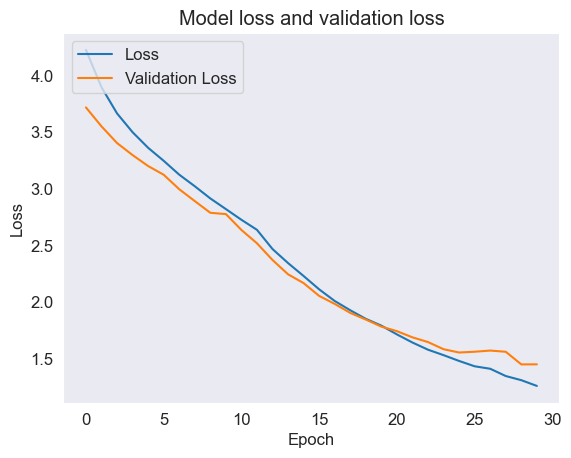

In [37]:
plt.plot(train_loss)
plt.plot(val_loss)

plt.title('Model loss and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [38]:
# this function make sure that an 
def index_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [39]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = index_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [42]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = caption_dict[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  6%|▌         | 1/17 [00:01<00:29,  1.85s/it]

BLEU-1: 0.448748
BLEU-2: 0.409081


 12%|█▏        | 2/17 [00:03<00:28,  1.88s/it]

BLEU-1: 0.485197
BLEU-2: 0.385774


 18%|█▊        | 3/17 [00:05<00:26,  1.88s/it]

BLEU-1: 0.367418
BLEU-2: 0.308728


 24%|██▎       | 4/17 [00:07<00:21,  1.69s/it]

BLEU-1: 0.404569
BLEU-2: 0.330170


 29%|██▉       | 5/17 [00:08<00:19,  1.60s/it]

BLEU-1: 0.443606
BLEU-2: 0.366159


 35%|███▌      | 6/17 [00:10<00:17,  1.58s/it]

BLEU-1: 0.466080
BLEU-2: 0.394539


 41%|████      | 7/17 [00:11<00:15,  1.54s/it]

BLEU-1: 0.491367
BLEU-2: 0.416756


 47%|████▋     | 8/17 [00:12<00:13,  1.49s/it]

BLEU-1: 0.490676
BLEU-2: 0.414202


 53%|█████▎    | 9/17 [00:14<00:12,  1.56s/it]

BLEU-1: 0.473944
BLEU-2: 0.397121


 59%|█████▉    | 10/17 [00:15<00:10,  1.51s/it]

BLEU-1: 0.489012
BLEU-2: 0.407416


 65%|██████▍   | 11/17 [00:18<00:10,  1.76s/it]

BLEU-1: 0.497258
BLEU-2: 0.416082


 71%|███████   | 12/17 [00:20<00:09,  1.92s/it]

BLEU-1: 0.516538
BLEU-2: 0.436344


 76%|███████▋  | 13/17 [00:22<00:08,  2.03s/it]

BLEU-1: 0.522052
BLEU-2: 0.439344


 82%|████████▏ | 14/17 [00:24<00:05,  1.97s/it]

BLEU-1: 0.517398
BLEU-2: 0.434634


 88%|████████▊ | 15/17 [00:26<00:03,  1.91s/it]

BLEU-1: 0.532388
BLEU-2: 0.447338


 94%|█████████▍| 16/17 [00:28<00:01,  1.91s/it]

BLEU-1: 0.547542
BLEU-2: 0.461613


100%|██████████| 17/17 [00:30<00:00,  1.80s/it]

BLEU-1: 0.552932
BLEU-2: 0.465929


In [43]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    #image_id = image_name.split('.')[0]
    img_path = os.path.join('C:/Users/pirat/Desktop/New folder (4) - Copy/fracture', image_name)
    image = Image.open(img_path)
    captions = caption_dict[image_name]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_name], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq startseq startseq this is simple fracture of the radius's styloid process. the fracture did not span the whole circle of the bone. the fracture was repaired utilizing the internal fixation procedure, wire, and plaster cast immobilization. endseq endseq endseq
--------------------Predicted--------------------
startseq startseq startseq this is fracture of the shaft of the whole circle of the bone and the whole circle of the bone endseq
---------------------Actual---------------------
startseq startseq startseq this is simple fracture of the shaft of the right femur that involved the full circumference of the bone, affecting the middle part of the shaft, and was corrected by using the internal fixation method, intramedullary nailing. endseq endseq endseq
--------------------Predicted--------------------
startseq startseq startseq this is fracture of the shaft of the femur involving the full circumference of the bone and the part o

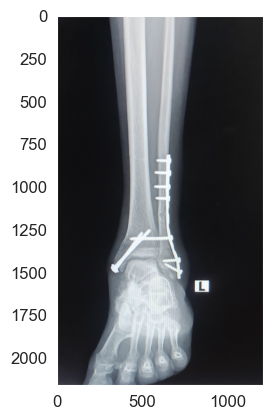

In [44]:
# display 15 images from the testing data

draws = random.sample(range(len(test)), 15)
for draw in draws:
    image_id = str(test[draw])
    generate_caption(image_id)